In [63]:
import numpy as np
from PIL import Image

def extract_16x16_block(image_path, x, y):
    """
    从给定的JPG图片中提取16x16像素块，并将其转换为灰度值存入二维矩阵中。

    参数:
        image_path (str): 图片文件路径
        x (int): 块的起始x坐标
        y (int): 块的起始y坐标

    返回:
        numpy.ndarray: 16x16的灰度值矩阵
    """
    # 打开图片并转换为灰度图
    img = Image.open(image_path).convert('L')

    # 确保图片大小足够大
    if img.width < x + 16 or img.height < y + 16:
        raise ValueError("指定的16x16块超出图片范围")

    # 提取16x16像素块
    block = img.crop((x, y, x + 16, y + 16))

    # 将像素块转换为numpy数组
    block_array = np.array(block)

    return block_array

image_path = "./img.png"  # 替换为你的图片路径
x = 900  # 起始x坐标
y = 600  # 起始y坐标
x1 = 904
y1 = 604

gray_block = extract_16x16_block(image_path, x, y)
pre_gray_block = extract_16x16_block(image_path, x1, y1)
print("16x16灰度值矩阵:")

print(gray_block)
print("16x16灰度值矩阵:")
print(pre_gray_block)

16x16灰度值矩阵:
[[142 142 142 142 141 141 140 139 138 138 136 135 133 133 133 133]
 [139 139 139 139 138 138 136 135 134 134 133 132 129 129 129 129]
 [133 133 133 133 132 132 131 129 128 128 127 126 124 124 124 124]
 [126 126 126 126 125 125 124 122 124 124 122 121 119 119 119 119]
 [120 120 120 120 119 119 119 119 119 119 119 119 118 118 117 117]
 [118 118 118 118 115 115 115 115 117 117 117 117 117 117 117 117]
 [117 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117]
 [117 117 117 117 117 117 117 117 117 117 117 117 117 117 117 117]
 [120 120 120 120 121 121 121 121 122 122 122 122 120 120 120 120]
 [122 122 122 122 125 125 125 125 126 126 126 126 124 124 124 124]
 [128 128 128 128 129 129 129 129 131 131 131 131 131 131 131 131]
 [133 133 133 133 133 133 133 133 134 134 134 134 134 134 134 134]
 [136 136 136 136 138 138 138 138 139 140 141 141 140 140 140 140]
 [140 140 140 140 141 141 141 141 141 141 141 141 140 140 140 140]
 [142 142 142 142 142 142 142 142 143 143 143 143 

# 流程
1. 输入4x4的图像或残差块X
2. 对X块进行4x4整数离散余弦变换，得到W块
3. 对W块进行比例缩放及量化
4. 是色度块或帧内16x16预测模式的亮度块？

    1. 是 对W中的直流分量进行hadamard变换，得到Y块
    2. 对Y块进行比例缩放及量化

5. 不是 输出


# 整数DCT变换
#### 对每个4x4残差块进行前向整数DCT变换，生成变换系数矩阵。此时，系数矩阵包含一个DC系数（左上角）和15个AC系数。

# DC系数的二次变换（哈达玛变换）
#### 特定模式处理：对于帧内16x16预测模式的亮度分量，所有4x4块的DC系数会被提取并组成一个新的4x4块。
#### 哈达玛变换：对该4x4 DC块进行4x4哈达玛变换，进一步去相关。哈达玛变换仅涉及加减运算，降低计算复杂度。

# 量化
#### DC系数：对哈达玛变换后的DC系数进行量化。由于DC系数代表低频信息，可能使用更粗的量化参数。
#### AC系数：对原始DCT变换后的AC系数进行量化，保留高频细节。

# 扫描与熵编码
#### 扫描顺序：DC块和AC系数按特定扫描顺序（如之字形）排列成一维序列。
#### 熵编码：使用CAVLC或CABAC对量化后的系数进行熵编码，生成最终的压缩比特流。

# 熵解码
#### 从比特流中解码出量化后的哈达玛DC系数和AC系数。

# 反量化
#### 对DC系数和AC系数分别进行反量化，恢复其变换域的幅值。

# 逆哈达玛变换（DC系数）
#### 对解码后的4x4 DC块进行逆哈达玛变换，得到原始的4x4 DC系数矩阵。
#### 将这些DC系数重新分配到对应4x4块的左上角位置。

# 逆整数DCT变换
#### 对每个4x4块的系数（包含恢复的DC系数和反量化后的AC系数）进行逆整数DCT变换，得到残差数据。

# 重建像素数据
#### 将残差数据与预测块相加，得到最终的像素值。

# 二次变换的目的：哈达玛变换进一步压缩DC系数的能量，提升编码效率。
#### 模式依赖性：仅帧内16x16模式的亮度块需进行DC系数的哈达玛变换；色度块的DC系数可能采用2x2哈达玛变换。

# JM源码实现：

#### 编码端：Transform4x4函数处理DCT，Hadamard4x4处理DC块；量化函数（如Quant4x4）分别处理DC/AC系数。
#### 解码端：Inverse4x4和InverseHadamard4x4实现逆变换，反量化后重构残差块。

残差块 → DCT变换 → 分离DC/AC系数 →
  ↓                  ↓
  ↓               各块AC系数量化 → 扫描 → 熵编码
  ↓
DC块哈达玛变换 → DC系数量化 → 扫描 → 熵编码

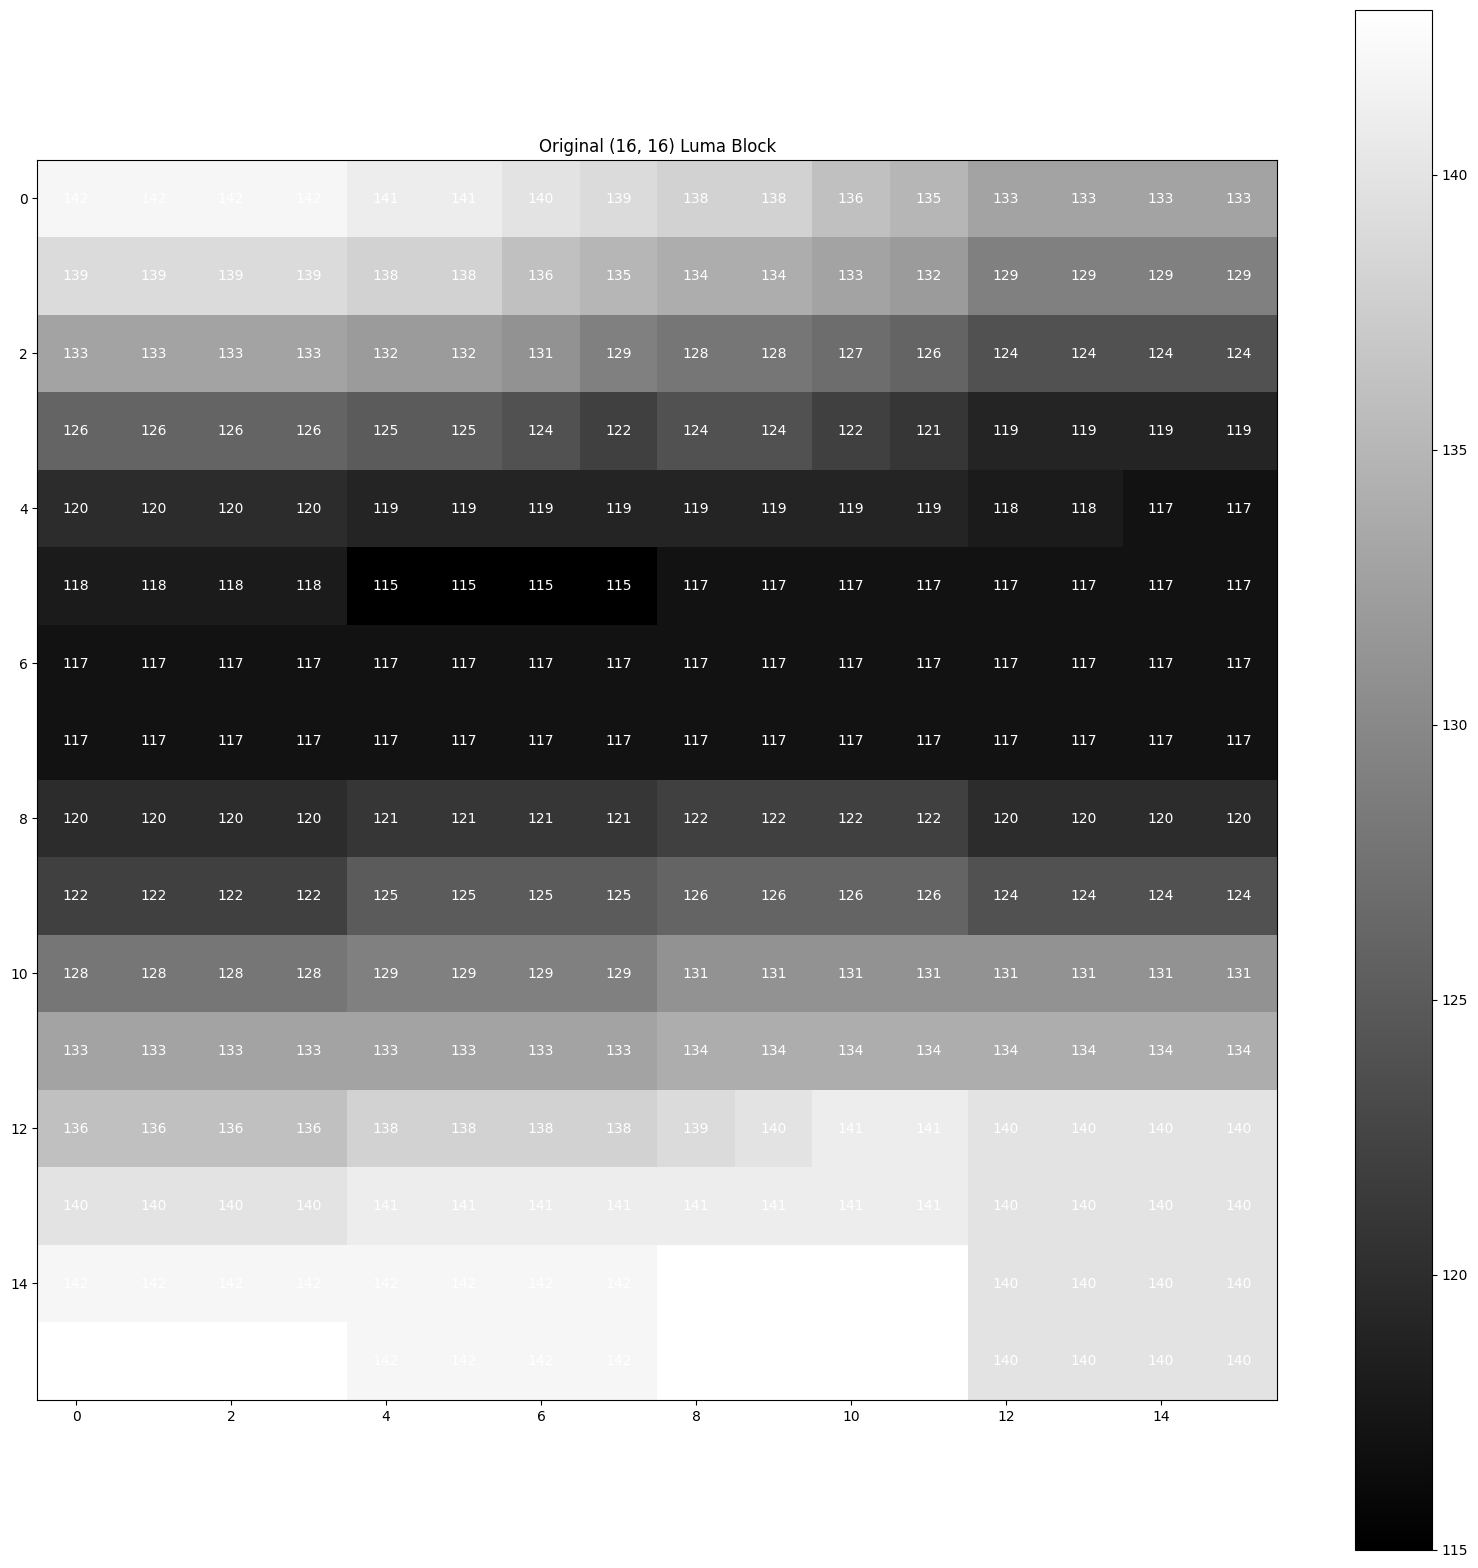

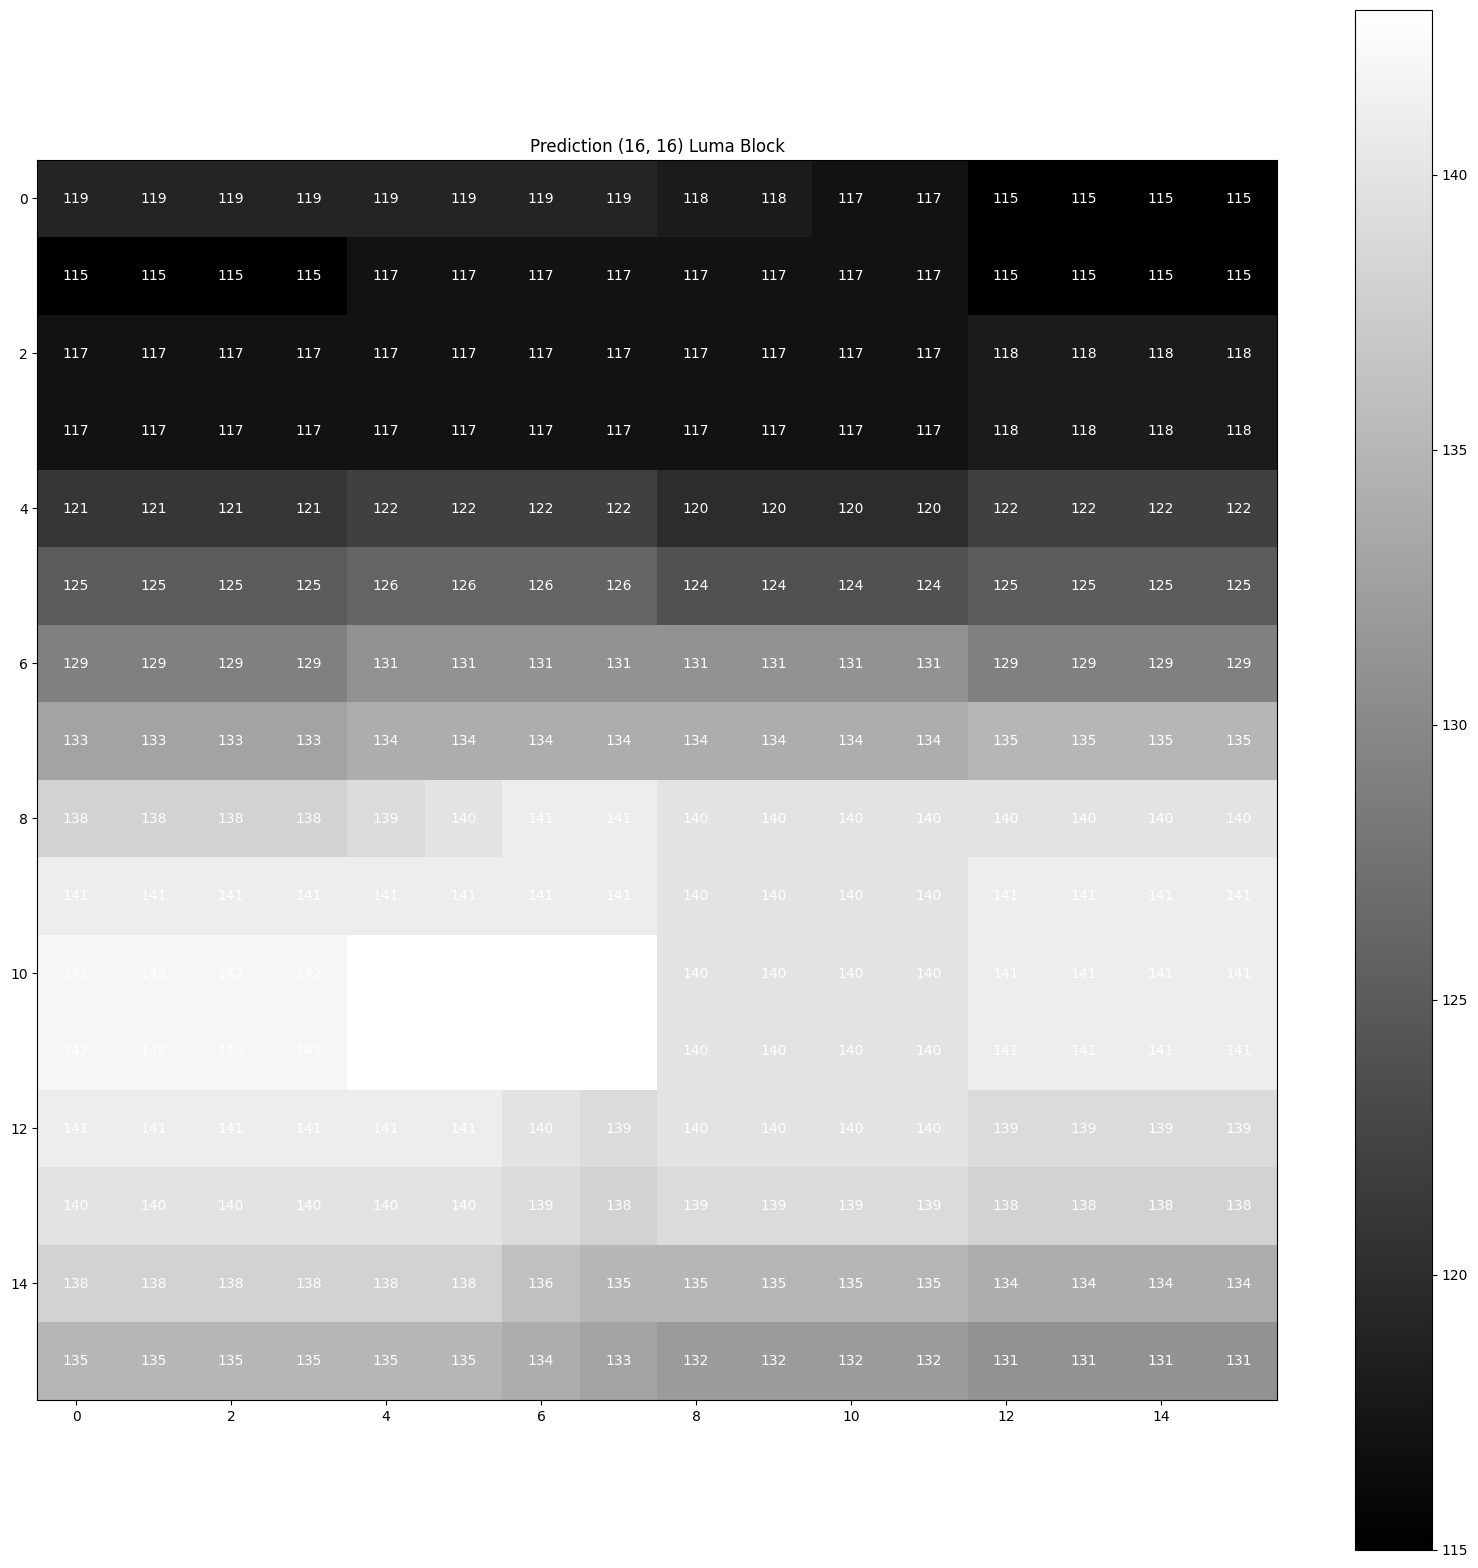

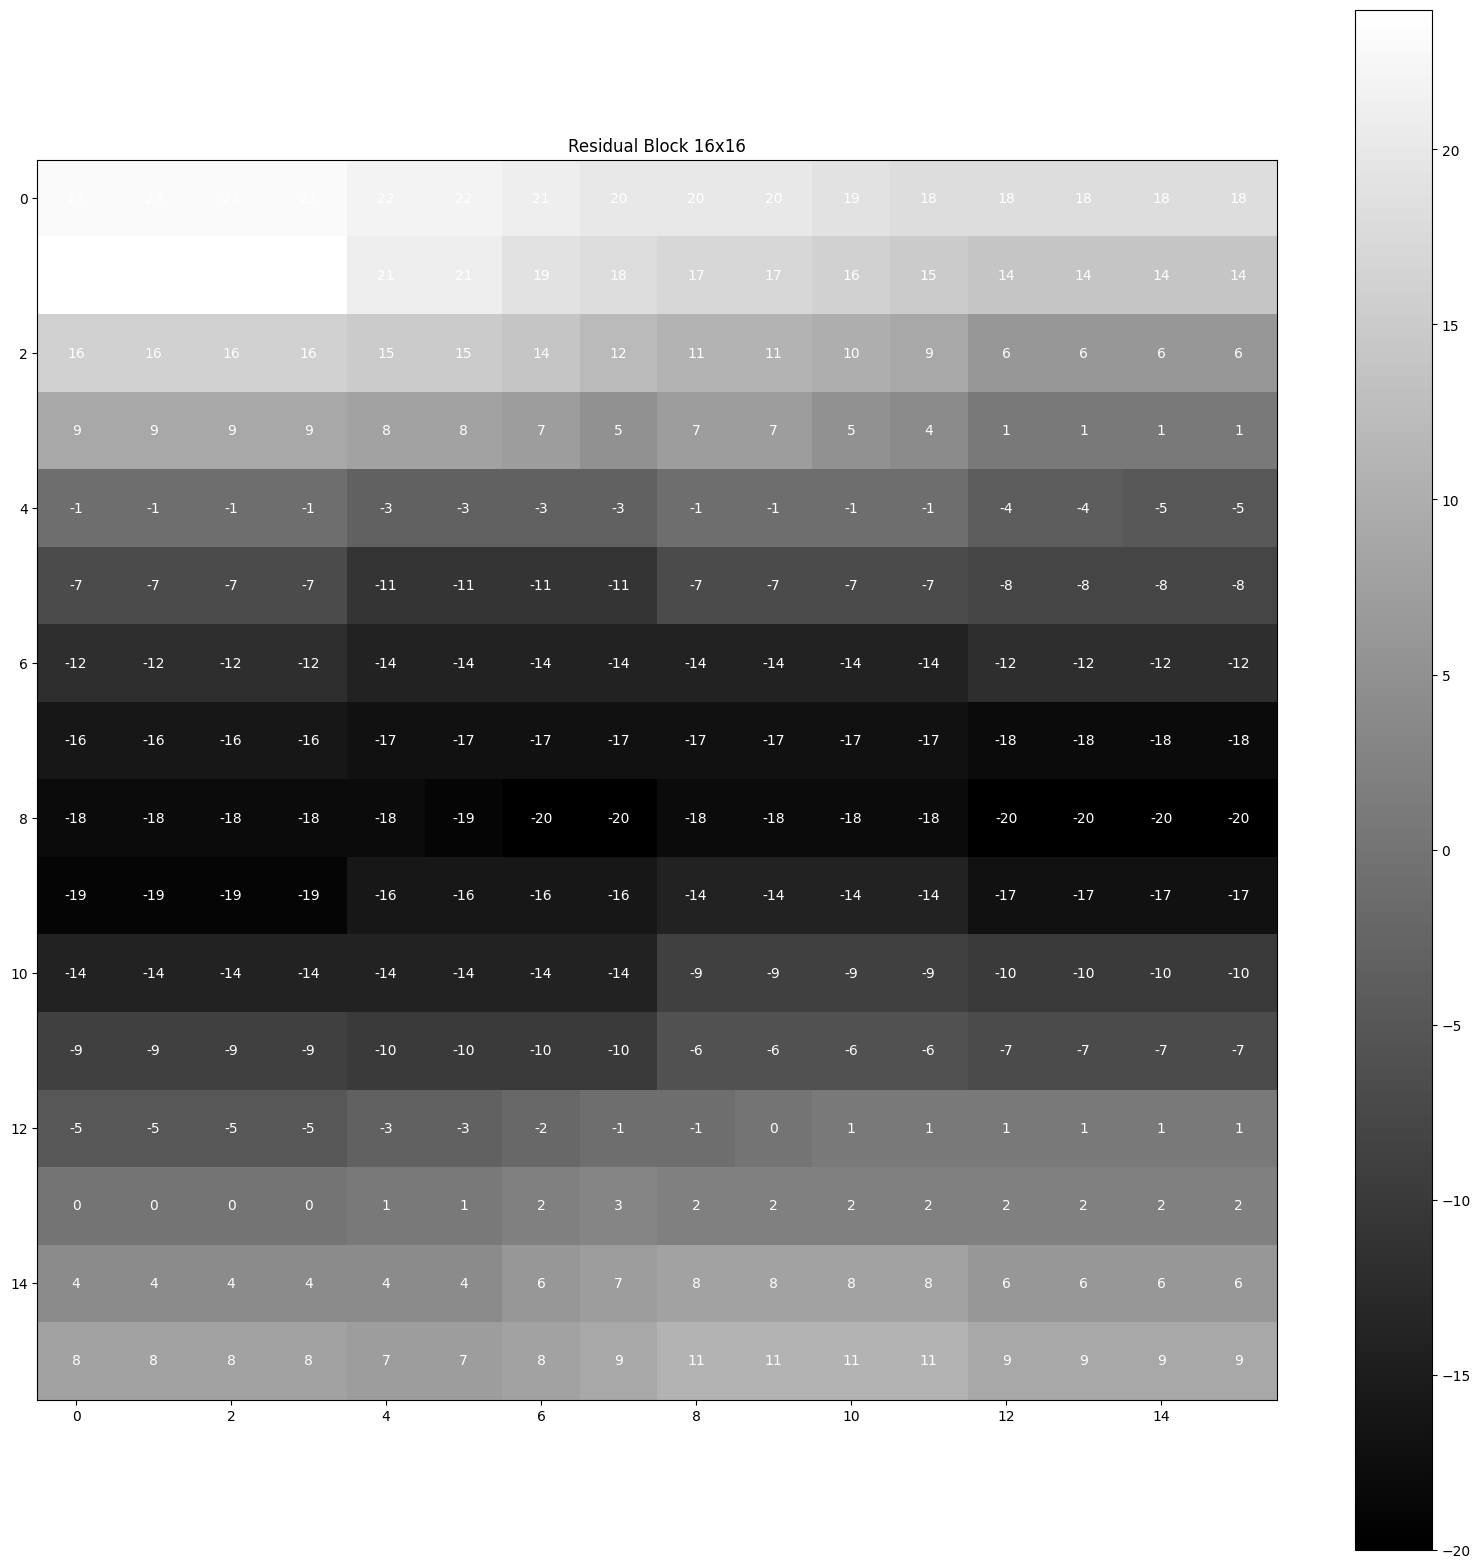

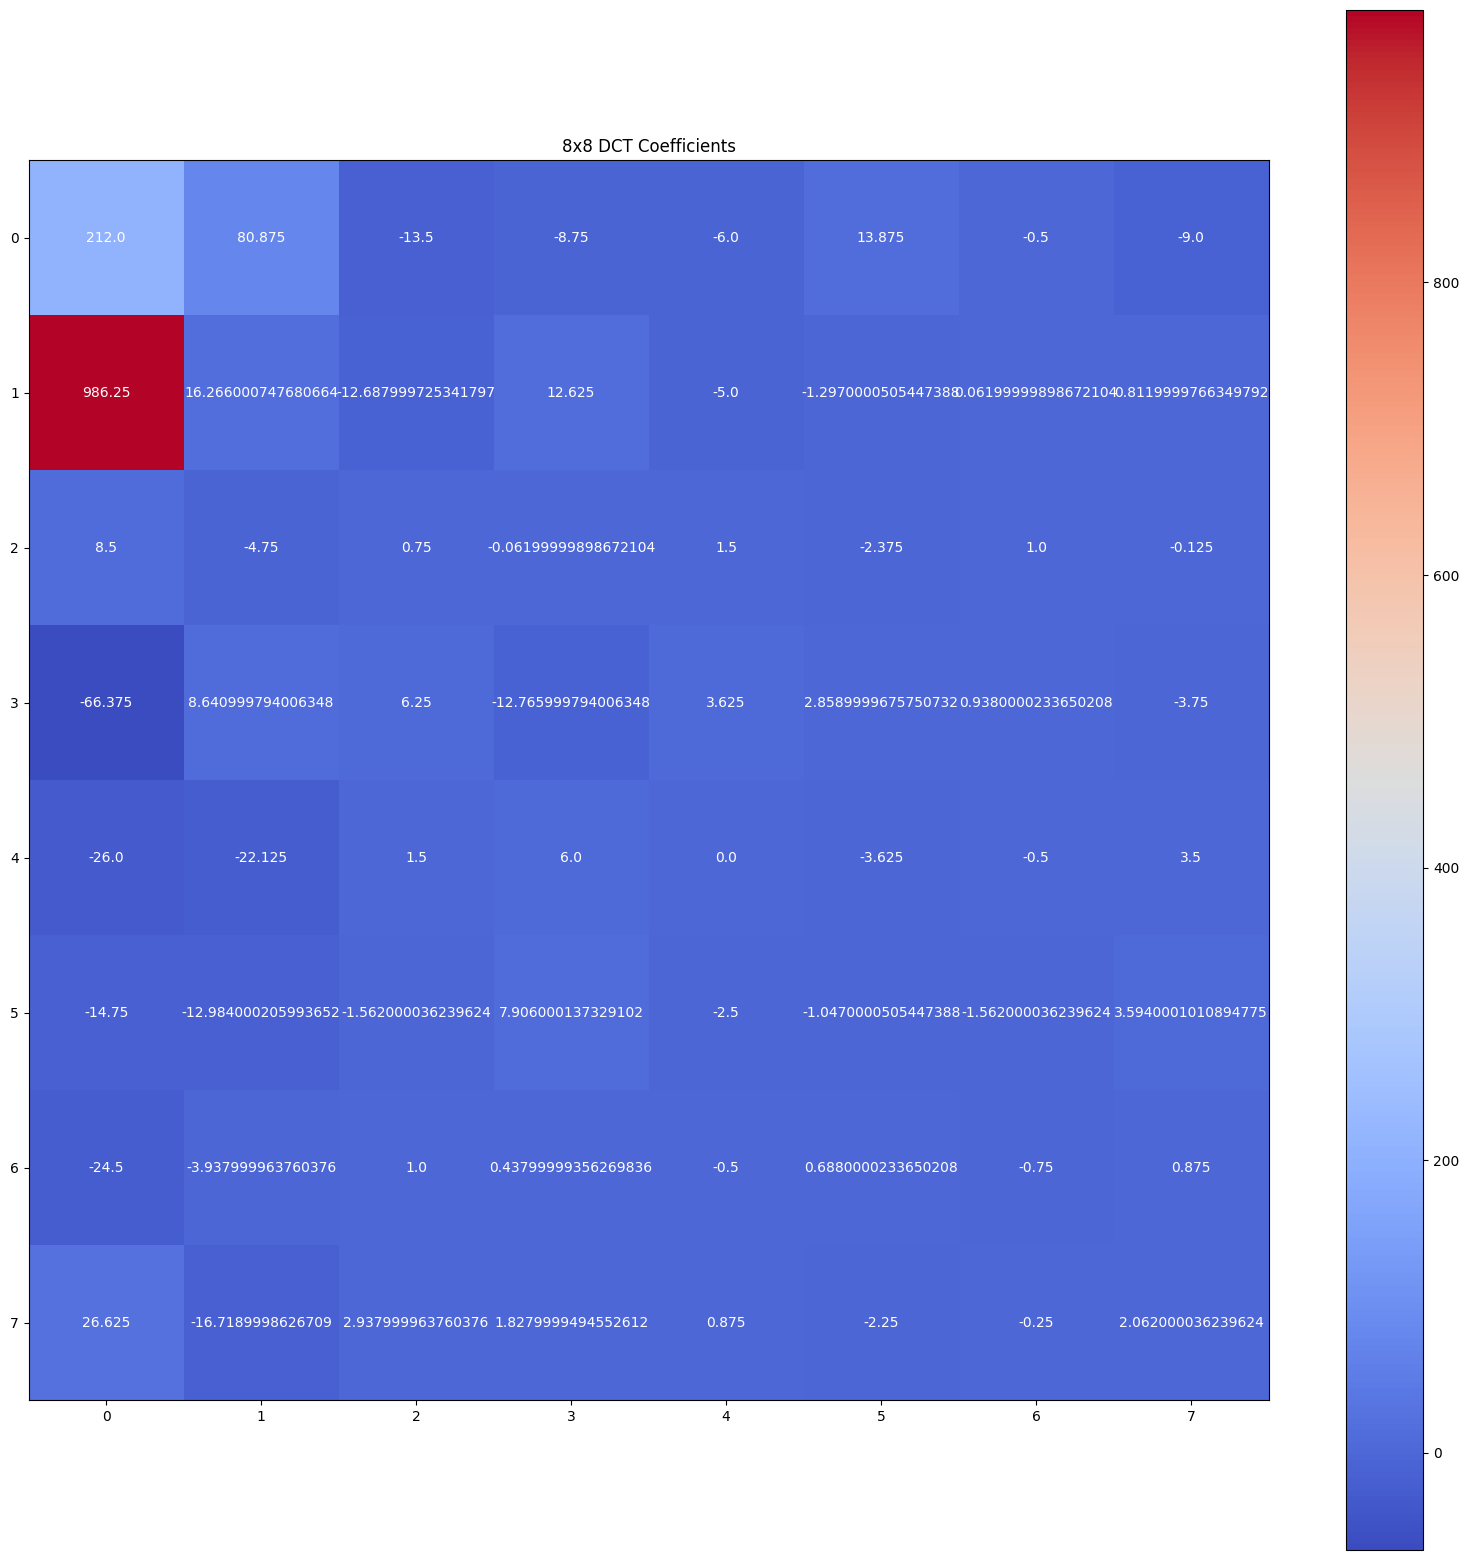

qp 0, scale 819.1875


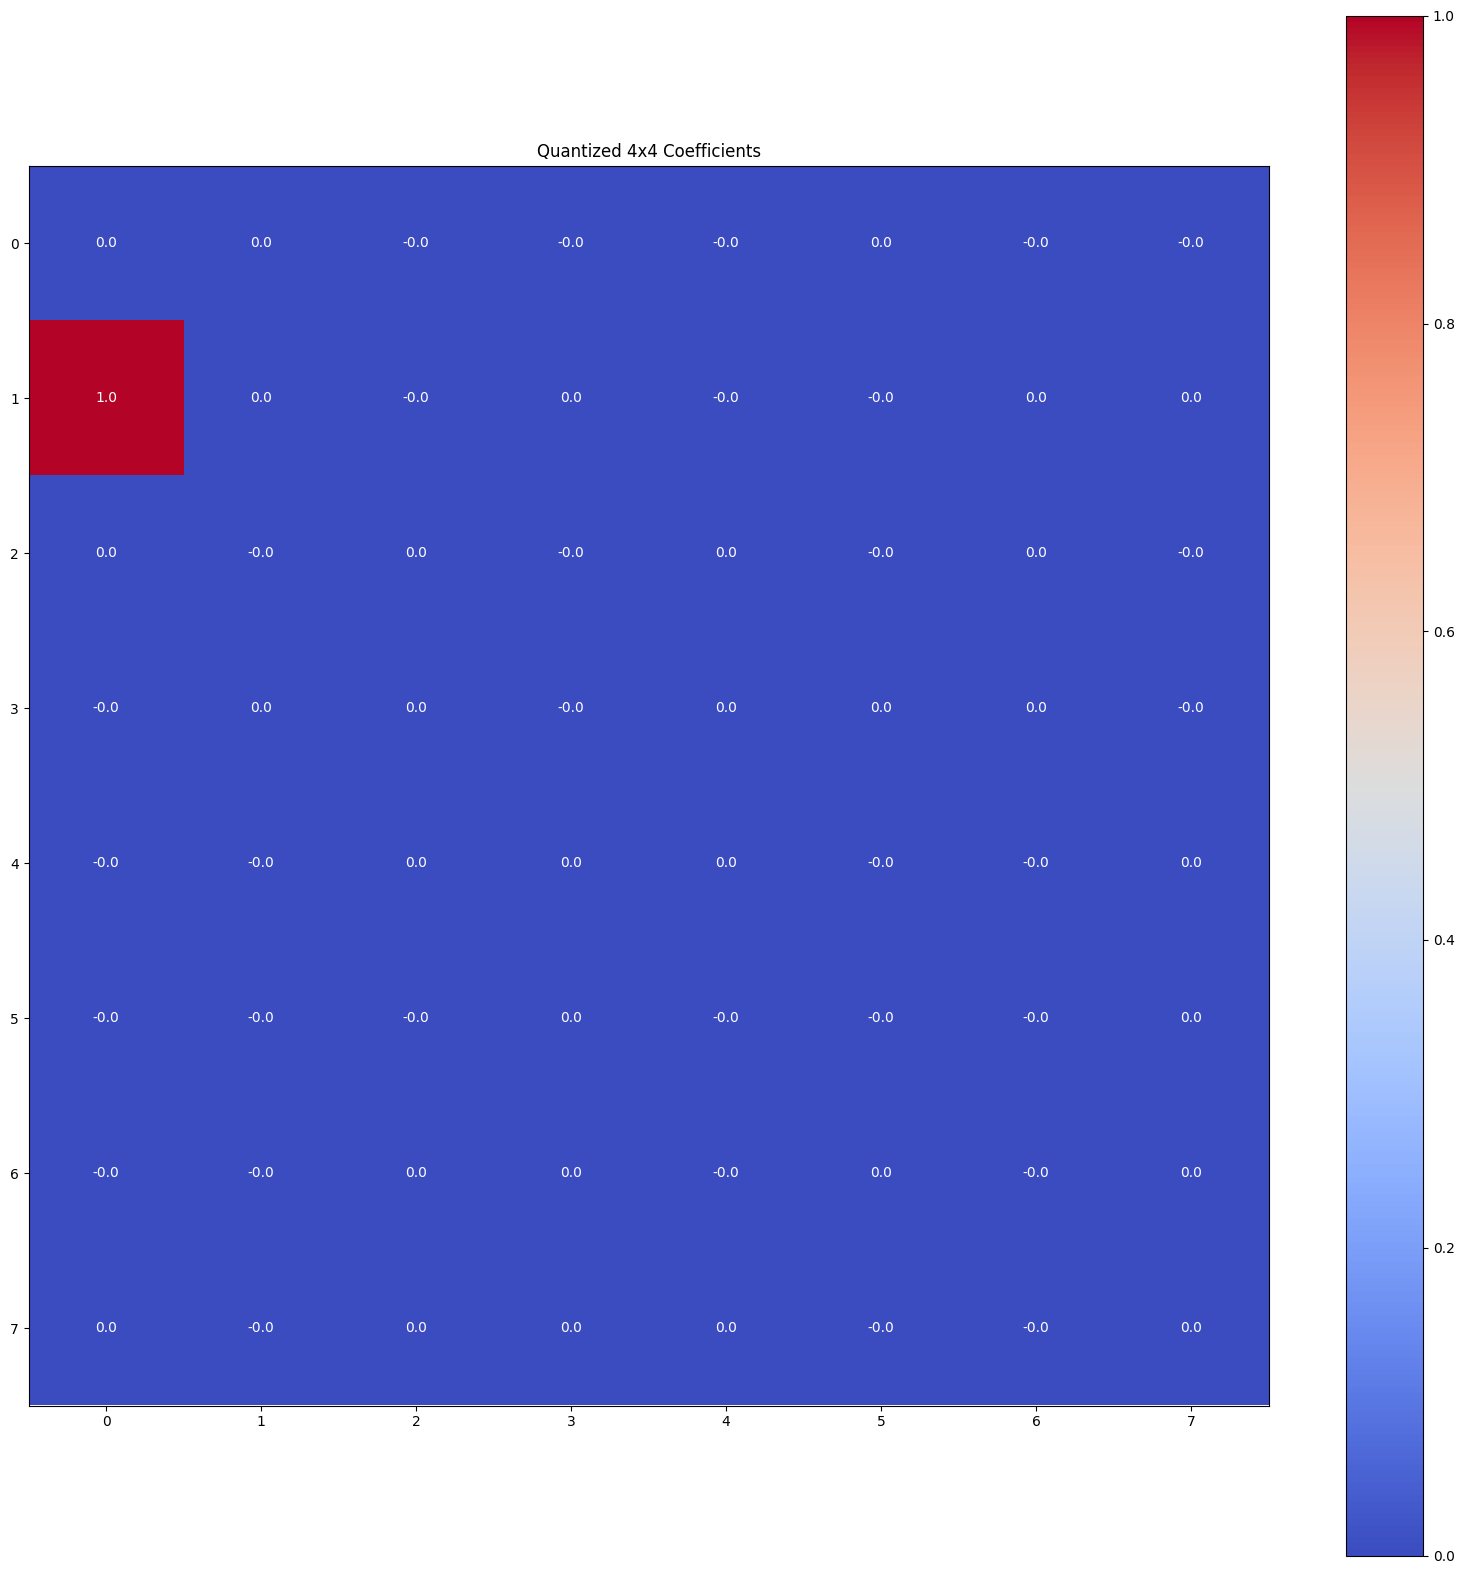

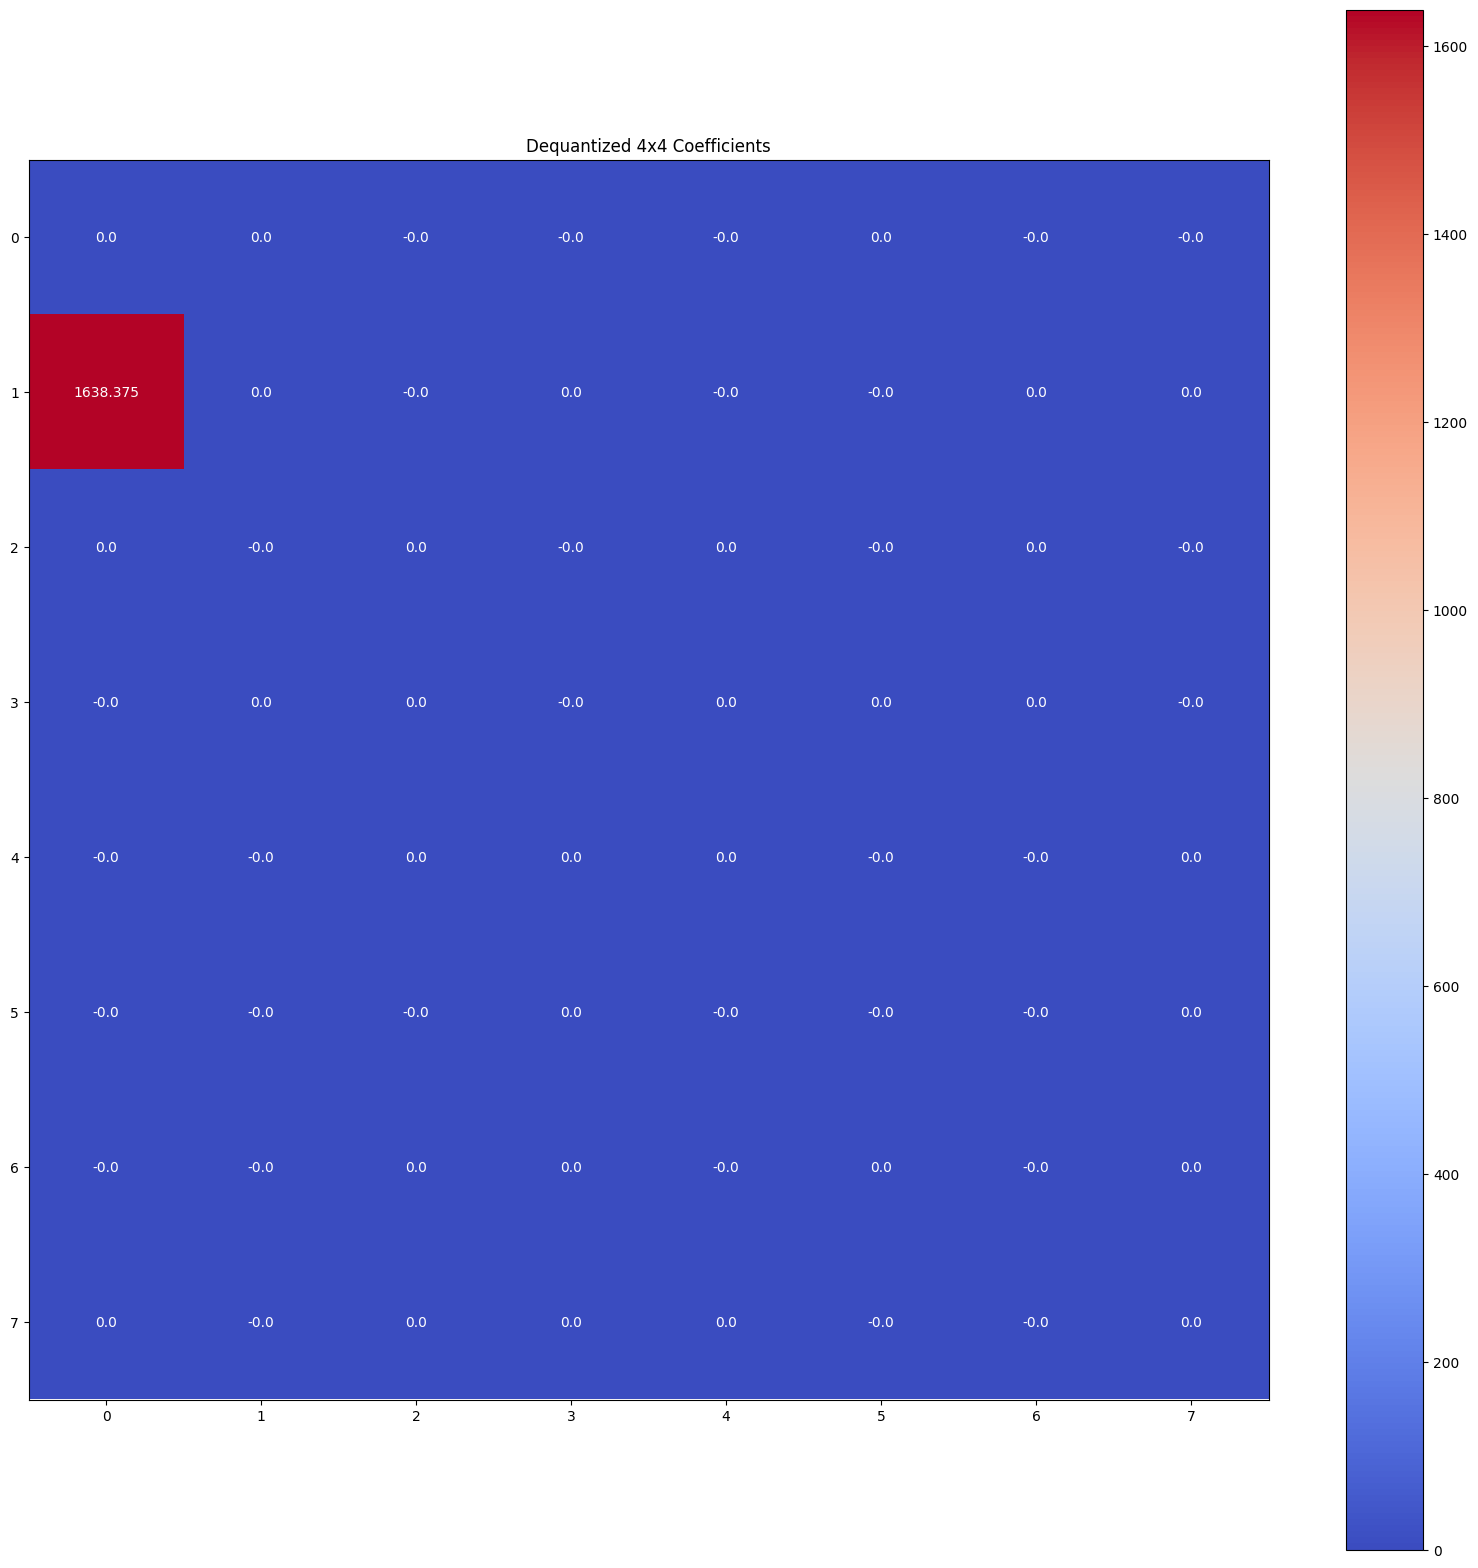

qp 0, scale 819.1875
qp 0, scale 819.1875
qp 0, scale 819.1875


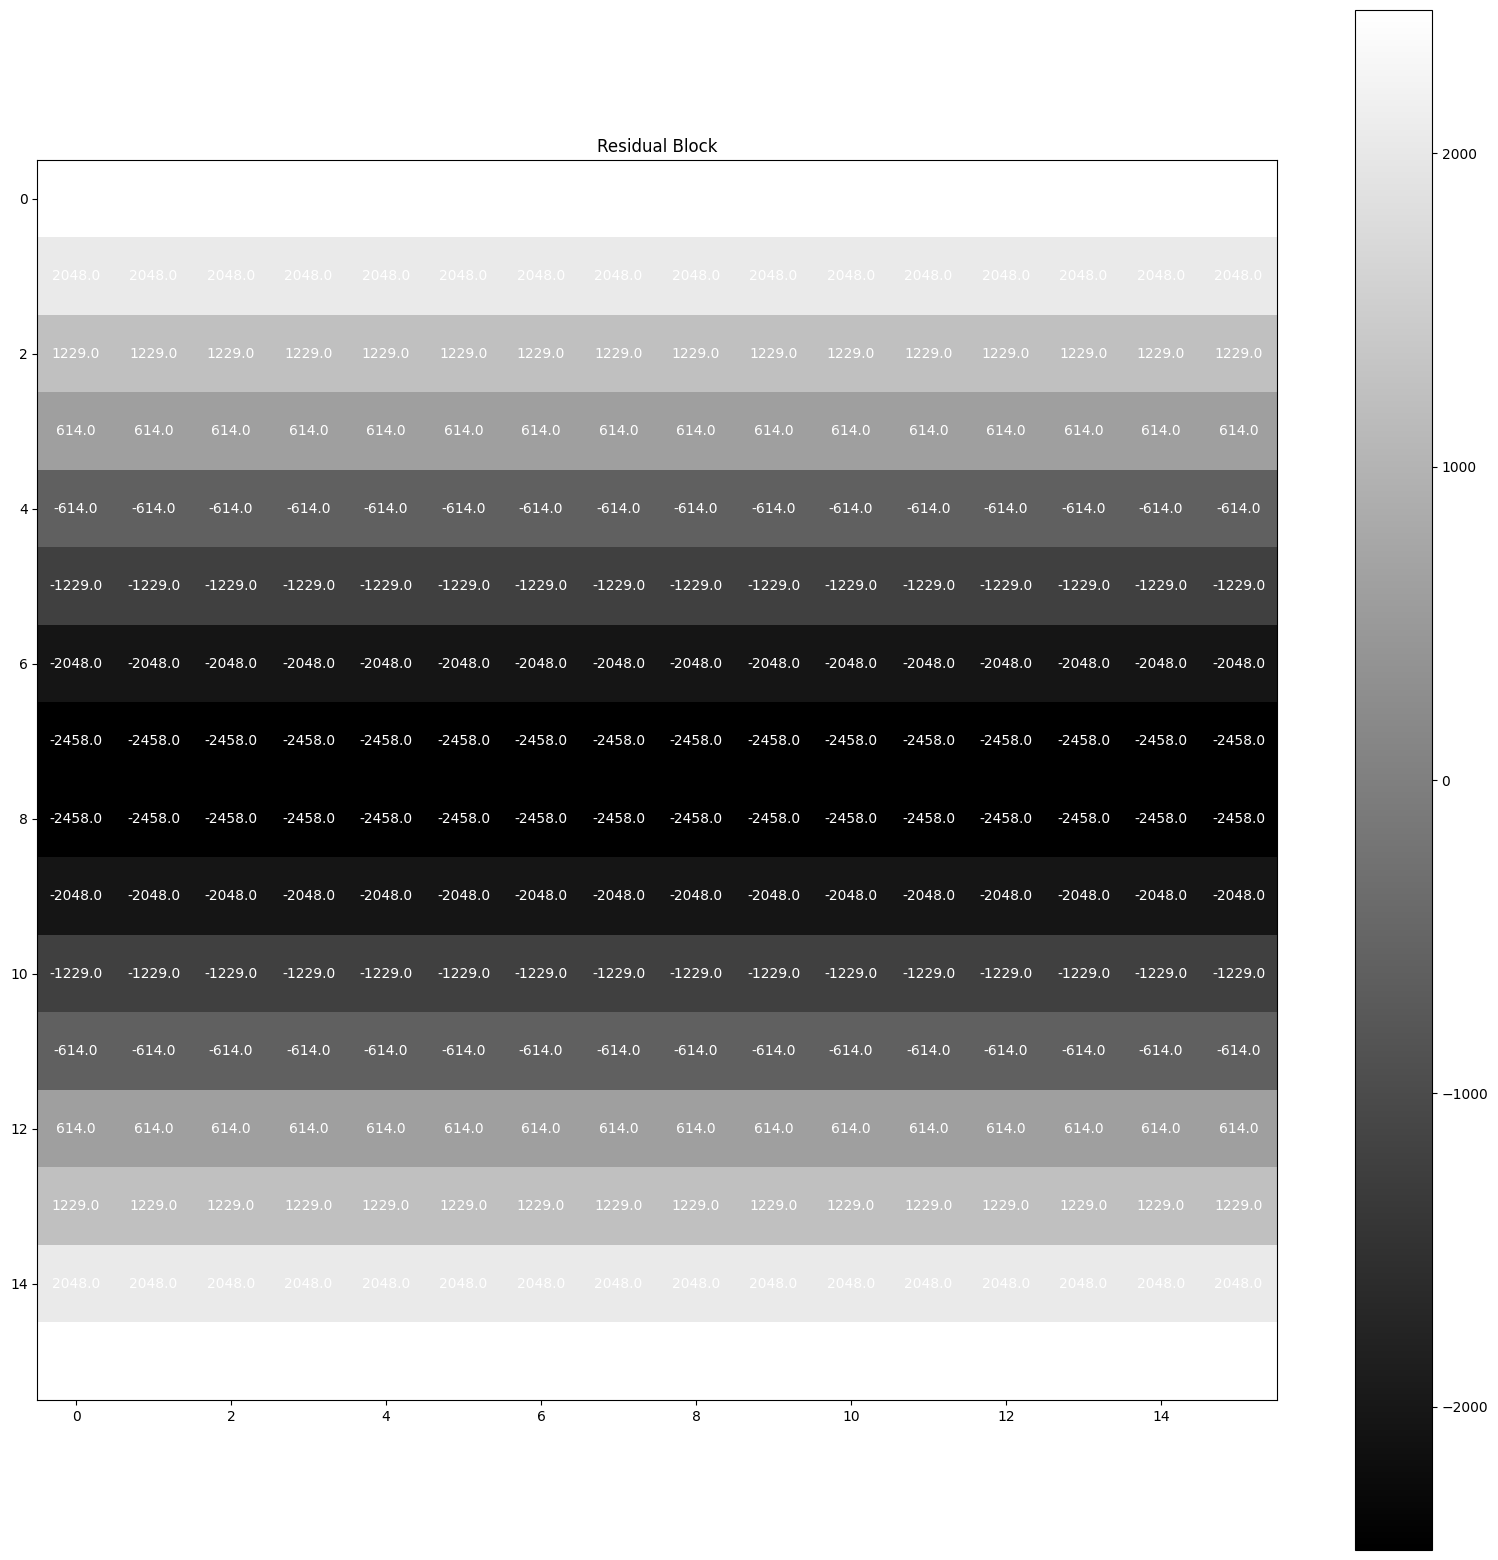

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def plot_matrix(data, title, cmap='viridis', annotate=True):
    """ 绘制矩阵热力图 """
    plt.figure(figsize=(20, 20))
    plt.imshow(data, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    if annotate:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(j, i, f"{data[i, j]}", ha='center', va='center', color='w')
    plt.show()

# ======================================================================
# 核心变换函数
# ======================================================================

# def dct4x4(block):
#     """ H.264 4x4 整数 DCT 变换 (Core 4x4 transform C14) """
#     H = np.array([[1, 1, 1, 1], [2, 1, -1, -2], [1, -1, -1, 1], [1, -2, 2, -1]], dtype=np.int32)
#     coeff = H @ block @ H.T
#     coeff = (coeff + 2) // 4  # 右移 2 位
#     return coeff
# 修改后的DCT4x4变换
def dct4x4(block):
    H = np.array([[1, 1, 1, 1],
                  [2, 1, -1, -2],
                  [1, -1, -1, 1],
                  [1, -2, 2, -1]], dtype=np.float32)  # <- 改为float32
    coeff = H @ block @ H.T
    coeff = coeff / 4.0  # 浮点除法代替右移
    return np.round(coeff * 1000) / 1000  # 保留3位小数

def hadamard4x4(block):
    """ 4x4 哈达玛变换（用于 DC 系数二次变换） """
    H = np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]], dtype=np.int32)
    return H @ block @ H.T

def dct8x8(block):
    H = np.array([
        [8, 8, 8, 8, 8, 8, 8, 8],
        [12, 10, 6, 3, -3, -6, -10, -12],
        [8, 4, -4, -8, -8, -4, 4, 8],
        [10, -3, -12, -6, 6, 12, 3, -10],
        [8, -8, -8, 8, 8, -8, -8, 8],
        [6, -12, 3, 10, -10, -3, 12, -6],
        [4, -8, 8, -4, -4, 8, -8, 4],
        [3, -6, 10, -12, 12, -10, 6, -3]], dtype=np.float32)  # 改为float32
    coeff = H @ block @ H.T
    coeff = coeff / 64.0  # 浮点除法
    return np.round(coeff * 1000) / 1000


# ======================================================================
# 量化与反量化
# ======================================================================

# 修正后的量化函数
def get_quant_scale(qp):
    """ JM标准的量化步长计算 """
    scale_table = [
        13107, 11916, 10082, 9362, 8192, 7282, 6554, 5826, 5243, 4660,  # QP 0-9
        4096, 3641, 3277, 2913, 2621, 2330, 2048, 1820, 1638, 1456,     # QP 10-19
        1311, 1165, 1024, 910, 819, 728, 655, 583, 512, 455,            # QP 20-29
        410, 364, 328, 291, 262, 233, 205, 182, 164, 146,               # QP 30-39
        131, 117, 102, 91, 82, 73, 66, 58, 51, 45,                      # QP 40-49
        41, 36, 33, 29, 26, 23, 21, 18, 16, 15                          # QP 50-51
    ]
    return scale_table[qp % 6] * (1 << (qp // 6)) / 16.0

# ======================== 量化函数 ========================
def quantize(coeff, qp, is_dc=False):
    scale = get_quant_scale(qp)

    if is_dc: scale *= 0.5  # DC系数更精细
    q_coeff = np.round(coeff / scale)

    print(f"qp {qp}, scale {scale}")
    return np.round(q_coeff * 1000) / 1000  # 保留3位小数

def dequantize(quant_coeff, qp, is_dc=False):
    scale = get_quant_scale(qp) * 2  # 反量化步长为量化步长的2倍
    if is_dc: scale *= 0.5
    coeff = quant_coeff * scale
    return np.round(coeff * 1000) / 1000


def inverse_dct4x4(coeff):
    """ H.264 4x4 整数逆 DCT 变换 (Core 4x4 transform C14) """
    H = np.array([[1, 1, 1, 1], [2, 1, -1, -2], [1, -1, -1, 1], [1, -2, 2, -1]], dtype=np.int32)
    block = H.T @ coeff @ H
    block = (block + 2) // 4  # 右移 2 位
    return block

def inverse_hadamard4x4(coeff):
    """ 4x4 逆哈达玛变换（用于 DC 系数二次变换） """
    H = np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]], dtype=np.int32)
    return H @ coeff @ H.T

def inverse_dct8x8(coeff):
    """ 8x8 整数逆 DCT 变换 (Core 8x8 transform C18) """
    H = np.array([
        [8, 8, 8, 8, 8, 8, 8, 8],
        [12, 10, 6, 3, -3, -6, -10, -12],
        [8, 4, -4, -8, -8, -4, 4, 8],
        [10, -3, -12, -6, 6, 12, 3, -10],
        [8, -8, -8, 8, 8, -8, -8, 8],
        [6, -12, 3, 10, -10, -3, 12, -6],
        [4, -8, 8, -4, -4, 8, -8, 4],
        [3, -6, 10, -12, 12, -10, 6, -3]
    ], dtype=np.int32)
    block = H.T @ coeff @ H
    block = (block + 32) // 64  # 右移 6 位
    return block

def z_scan(block):
    """ Z 形扫描 4x4 块 """
    order = [0, 1, 4, 8, 5, 2, 3, 6, 9, 12, 13, 10, 7, 11, 14, 15]
    return block.flatten()[order]

# ======================================================================
# 主流程
# ======================================================================

def process_dc_coefficients(dc_coeffs, qp):
    dc_block = np.array(dc_coeffs).reshape(4,4).astype(np.float32)
    hadamard = hadamard4x4(dc_block)
    quant_dc = quantize(hadamard, qp, is_dc=True)
    dequant_dc = dequantize(quant_dc, qp, is_dc=True)
    reconstructed_dc = inverse_hadamard4x4(dequant_dc)
    return np.round(reconstructed_dc * 1000) / 1000

def process_16x16_luma(block_16x16, pre_block_16x16, qp, mode='default'):
    """
    处理 16x16 亮度块
    """
    # 划分为 4x4 子块
    sub_blocks = [block_16x16[i:i+4, j:j+4] for i in range(0, 16, 4) for j in range(0, 16, 4)]
    pre_sub_blocks = [pre_block_16x16[i:i+4, j:j+4] for i in range(0, 16, 4) for j in range(0, 16, 4)]
    
    # 确保残差块为浮点数类型
    residual_blk16x16 = np.zeros((16, 16), dtype=np.float16)
    plot_matrix(block_16x16.astype(np.int16) - pre_block_16x16.astype(np.int16), "Residual Block 16x16", cmap='gray')
    
    if mode == 'intra16x16':
        dc_coeffs = []
        for idx, (blk, pre_blk) in enumerate(zip(sub_blocks, pre_sub_blocks)):
            # 4x4 变换，确保输入为浮点数
            residual = blk.astype(np.float32) - pre_blk.astype(np.float32)
            coeff = dct4x4(residual)  # DCT 变换结果为浮点数
            if idx == 0:
                plot_matrix(coeff, f"4x4 DCT Coefficients (Block {idx})", cmap='coolwarm')

            dc_coeffs.append(coeff[0, 0])  # 收集 DC 系数

            coeff[0, 0] = 0 # DC系数直接置为0
            # 量化 AC 系数，结果为浮点数
            quant_ac = quantize(coeff, qp).astype(np.float32)

            if idx == 0:
                plot_matrix(quant_ac, f"Quantized AC (Block {idx})", cmap='coolwarm')

            # 反量化 AC 系数，结果为浮点数
            dequant_ac = dequantize(quant_ac, qp).astype(np.float32)
            if idx == 0:
                plot_matrix(dequant_ac, f"Dequantized AC (Block {idx})", cmap='coolwarm')

            # 逆 DCT 变换，结果为浮点数
            reconstructed_residual = inverse_dct4x4(dequant_ac).astype(np.float32)
            if idx == 0:
                plot_matrix(reconstructed_residual, f"Reconstructed Residual (Block {idx})", cmap='coolwarm')

            i = idx // 4
            j = idx % 4
            # 基于AC分量获取重构块
            residual_blk16x16[i * 4:(i + 1) * 4, j * 4:(j + 1) * 4] = reconstructed_residual
            plot_matrix(residual_blk16x16, "AC Residual Block 16x16", cmap='gray')

        plot_matrix(dc_coeffs, "DC Coefficients", cmap='coolwarm')
        reconstructed_residual_dc_blk4x4 = process_dc_coefficients(dc_coeffs, qp)
        for i in range(reconstructed_residual_dc_blk4x4.shape[0]):
            for j in range(reconstructed_residual_dc_blk4x4.shape[1]):
                # 补充DC分量的残差
                residual_blk16x16[i * 4, j * 4] += reconstructed_residual_dc_blk4x4[i, j]

        residual_blk16x16 = residual_blk16x16.astype(np.int16)

    elif mode == '8x8':
        for i in range(0, 16, 8):
            for j in range(0, 16, 8):
                blk_8x8 = block_16x16[i:i+8, j:j+8].astype(np.float32)
                pre_blk_8x8 = pre_block_16x16[i:i+8, j:j+8].astype(np.float32)
                coeff = dct8x8(blk_8x8 - pre_blk_8x8).astype(np.float32)
                if i == 0 and j == 0:
                    plot_matrix(coeff, "8x8 DCT Coefficients", cmap='coolwarm')
                
                quant_coeff = quantize(coeff, qp).astype(np.float32)
                if i == 0 and j == 0:
                    plot_matrix(quant_coeff, "Quantized 4x4 Coefficients", cmap='coolwarm')
                
                dequant_coeff = dequantize(quant_coeff, qp).astype(np.float32)
                if i == 0 and j == 0:
                    plot_matrix(dequant_coeff, "Dequantized 4x4 Coefficients", cmap='coolwarm')
                
                reconstructed_residual = inverse_dct8x8(dequant_coeff).astype(np.int16)
                residual_blk16x16[i : i + 8, j : j + 8] = reconstructed_residual
    
    else:
        for idx, (blk, pre_blk) in enumerate(zip(sub_blocks, pre_sub_blocks)):
            coeff = dct4x4(blk.astype(np.float32) - pre_blk.astype(np.float32)).astype(np.float32)
            if idx == 0:
                plot_matrix(coeff, f"4x4 DCT Coefficients (Block {idx})", cmap='coolwarm')
            
            quant_coeff = quantize(coeff, qp).astype(np.float32)
            if idx == 0:
                plot_matrix(quant_coeff, f"Quantized Coefficients (Block {idx})", cmap='coolwarm')
            
            dequant_coeff = dequantize(quant_coeff, qp).astype(np.float32)
            if idx == 0:
                plot_matrix(dequant_coeff, f"Dequantized Coefficients (Block {idx})", cmap='coolwarm')
            
            reconstructed_residual = inverse_dct4x4(dequant_coeff).astype(np.float32)
            if idx == 0:
                plot_matrix(reconstructed_residual, f"Reconstructed Residual (Block {idx})", cmap='coolwarm')
            
            i = idx // 4
            j = idx % 4
            residual_blk16x16[4 * i : (i + 1) * 4, 4 * j : (j + 1) * 4] = reconstructed_residual.astype(np.int16)
    
    plot_matrix(residual_blk16x16, "Residual Block", cmap='gray')


# ======================================================================
# 示例运行
# ======================================================================

if __name__ == "__main__":
    # 生成示例 16x16 亮度块（随机残差数据）
    np.random.seed(1)
    # plot_matrix()
    block_16x16 = gray_block #np.random.randint(0, 256, (16, 16))

    text = f"Original {block_16x16.shape} Luma Block"
    text2 = f"Prediction {block_16x16.shape} Luma Block"
    # 可视化原始块
    plot_matrix(block_16x16, text, cmap='gray')
    plot_matrix(pre_gray_block, text2, cmap='gray')

    # 处理不同模式
    # process_16x16_luma(block_16x16, pre_gray_block, qp=24, mode='default')       # 默认 4x4 流程
    # process_16x16_luma(block_16x16, pre_gray_block, qp=24, mode='intra16x16')   # 16x16 帧内预测
    process_16x16_luma(block_16x16, pre_gray_block, qp=0, mode='8x8')          # 8x8 变换